<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Открываем-файл-с-данными-и-изучаем-общую-информацию." data-toc-modified-id="Открываем-файл-с-данными-и-изучаем-общую-информацию.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Открываем файл с данными и изучаем общую информацию.</a></span></li><li><span><a href="#Предобработка-данных,-продолжаем-изучать-данные" data-toc-modified-id="Предобработка-данных,-продолжаем-изучать-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных, продолжаем изучать данные</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты эксперимента</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Изучение воронки продаж. Анализ A/B эксперимента

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.  
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  
После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нам предстоит выяснить какой шрифт лучше

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
import datetime as dt
sns.set_style("darkgrid")

In [2]:
# функция расчета  z-критерия для двух групп
def z_test(successes_1, successes_2, trials_1, trials_2, alpha=0.05, bonferroni_alpha = 1): 
    alpha = alpha / bonferroni_alpha # критический уровень статистической значимости
    successes = np.array([successes_1,successes_2])
    trials = np.array([trials_1, trials_2])


    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    print('значение alpha:', alpha)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [3]:
# функция расчета  z-критерия для трех групп
def all_group_z_test(group, alpha=0.05, bonferroni_alpha = 1):
    group = group
    while group < 248:
        for i in group_events_by_users['eventname'].unique():
            print(f'Статистически значимые различая между группами {group} и {group + 1} для события {i}')

            z_test(group_events_by_users.loc[group_events_by_users['eventname'] == i, str(group)], 
                   group_events_by_users.loc[group_events_by_users['eventname'] == i, str(group + 1)], 
                   trials_1 = unique_user.loc[group], 
                   trials_2 = unique_user.loc[group + 1], 
                   alpha = alpha, 
                   bonferroni_alpha = bonferroni_alpha)
            print()
            print('---')
            print()
        group = group + 1
        print()
        print() 
        print() 

    for i in group_events_by_users['eventname'].unique():
        print(f'Статистически значимые различая между группами {group - 2} и {group } для события {i}')
        z_test(group_events_by_users.loc[group_events_by_users['eventname'] == i, str(group -2)], 
               group_events_by_users.loc[group_events_by_users['eventname'] == i, str(group)], 
               trials_1 = unique_user.loc[group - 2], 
               trials_2 = unique_user.loc[group],
               alpha = alpha,
               bonferroni_alpha = bonferroni_alpha)
        print()
        print('---')
        print() 

### Открываем файл с данными и изучаем общую информацию.

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df = pd.read_csv('csv/mobile_apps.csv', sep=',')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Описание данных**  

Каждая запись в логе — это действие пользователя, или событие.   
`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

In [6]:
# df.to_csv('logs_exp.csv', index=False) 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
df.isna().agg({'sum', 'mean'})

,EventName,DeviceIDHash,EventTimestamp,ExpId
mean,0.0,0.0,0.0,0.0
sum,0.0,0.0,0.0,0.0


In [9]:
print('Количество уникальных значений в каждой колонке:')
for index in df.columns:
    row = df[index].nunique()
    print(f'Уникальный значений {index}: {row}')

Количество уникальных значений в каждой колонке:
Уникальный значений EventName: 5
Уникальный значений DeviceIDHash: 7551
Уникальный значений EventTimestamp: 176654
Уникальный значений ExpId: 3


In [10]:
total_unique_users = df['DeviceIDHash'].nunique()

Посомтрим на распределение событий 

In [11]:
df['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

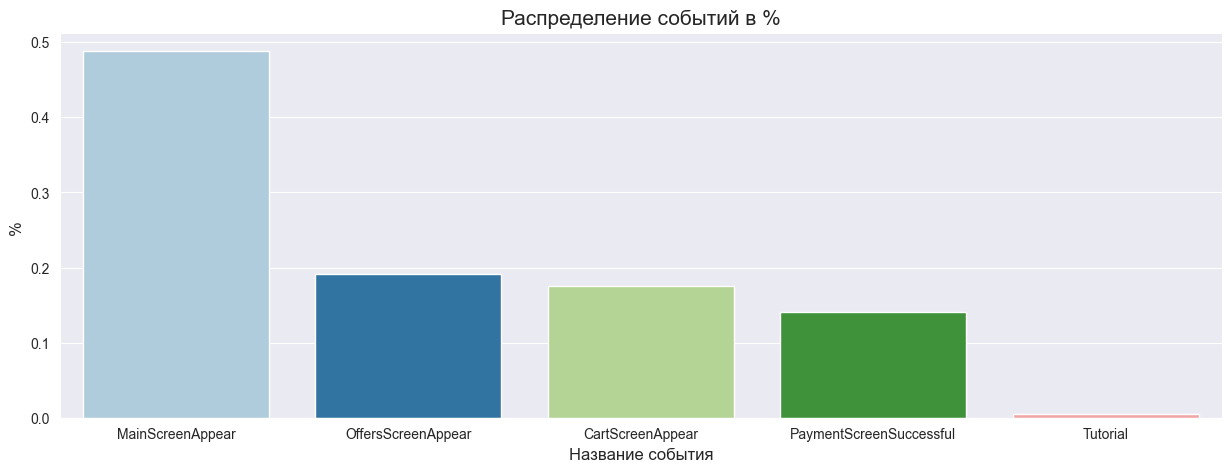

In [12]:
t = df["EventName"].value_counts(normalize=True)

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Название события',fontsize=12)
g.set_ylabel('% ', fontsize=12)
g.set_title('Распределение событий в %', fontsize=15)
plt.show()

На графике мы видим, что чаще всего пользователи бывают на главной странице и меньше половины пользователей доходит до экрана предложений и далее совершает заказ.

`MainScreenAppear`  главный экран  
`OffersScreenAppear` экран предложений  
`CartScreenAppear`  экран корзины  
`PaymentScreenSuccessful` оплата прошла успешно  
`Tutorial` руководство  

Посомтрим на распределение действий пользователей в каждой группе.

In [13]:
df['ExpId'].value_counts(normalize=True)

248    0.351241
246    0.328945
247    0.319814
Name: ExpId, dtype: float64

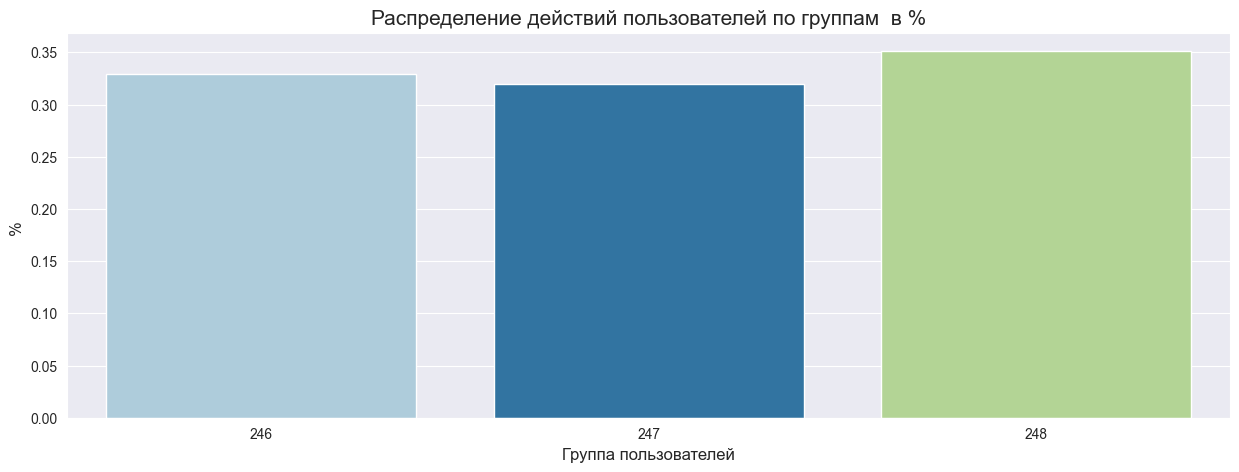

In [14]:
t = df["ExpId"].value_counts(normalize=True)

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Группа пользователей',fontsize=12)
g.set_ylabel('% ', fontsize=12)
g.set_title('Распределение действий пользователей по группам  в %', fontsize=15)
plt.show()

Посомтрим на распределение пользователей по группам

In [15]:
df.groupby('ExpId')['DeviceIDHash'].nunique()

ExpId
246    2489
247    2520
248    2542
Name: DeviceIDHash, dtype: int64

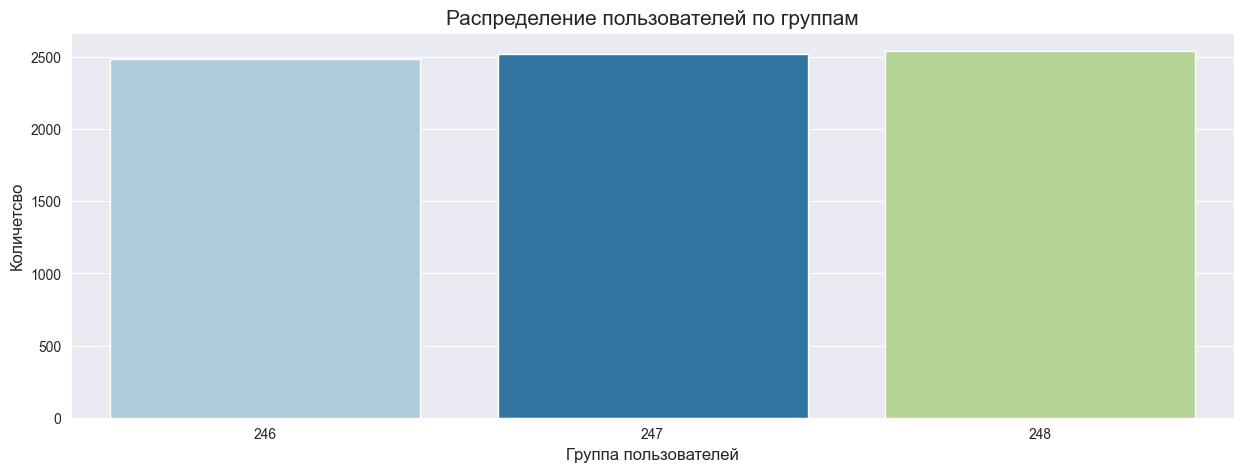

In [16]:
t = df.groupby('ExpId')['DeviceIDHash'].nunique()

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Группа пользователей',fontsize=12)
g.set_ylabel('Количетсво', fontsize=12)
g.set_title('Распределение пользователей по группам', fontsize=15)
plt.show()

Визуально складывается ощущение, что пользователи и их действия распределены по группам равномерно 

**Вывод:**  
У нас есть датафрейм, 244126 строчек, три группы, 5 событий. 7551 пользователь     
Проупсков нет, Timestamp приведём  к привычной дате, название колонок приведём  к нижнему регистру.

### Предобработка данных, продолжаем изучать данные 

In [17]:
df.columns =[h.lower() for h in df.columns]
df.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

In [18]:
df.columns = ['eventname', 'user_id', 'eventtimestamp', 'group']

In [19]:
df['date_time'] = pd.to_datetime(df['eventtimestamp'], unit='s')

In [20]:
df['date'] = df['date_time'].dt.date

Проверим на наличие дубликатов

In [21]:
df.duplicated().sum()

413

In [22]:
df[df.duplicated(keep=False)].iloc[0:5]

,eventname,user_id,eventtimestamp,group,date_time,date
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2348,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3572,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01


In [23]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [24]:
df[df['eventtimestamp'] == 1564474784]

,eventname,user_id,eventtimestamp,group,date_time,date
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30


In [25]:
len(df)

243713

Посмотрим, сколько действий делают пользователи в приложении

In [26]:
t = df.groupby('user_id')['eventname'].count().sort_values(ascending=False)
t.head()

user_id
6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
Name: eventname, dtype: int64

Среднее значение: 32.28
Медианное значение: 20.0
Минимальное значение: 1
Максимальное значение: 2307


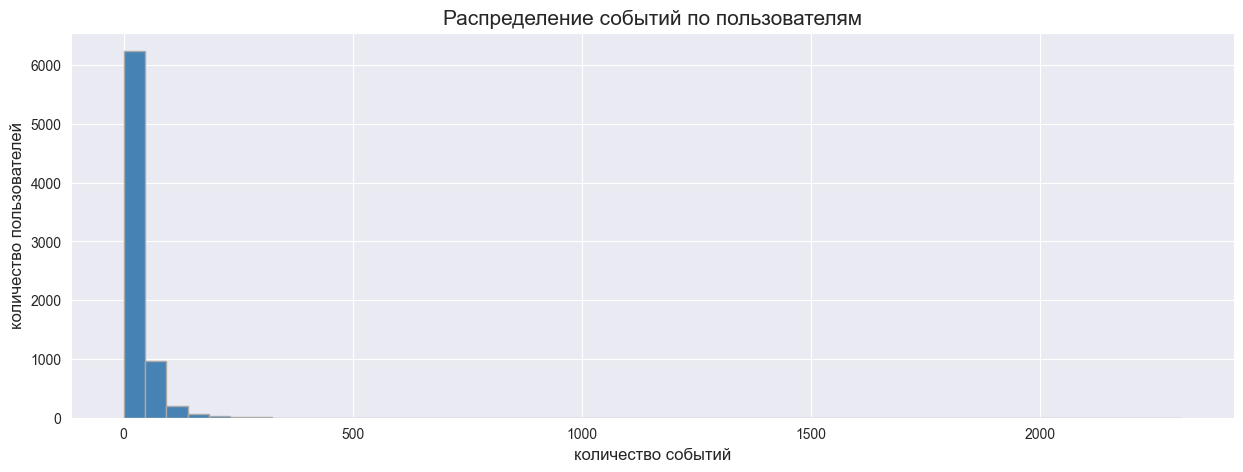

In [27]:
print(f'Среднее значение: {t.mean().round(2)}')
print(f'Медианное значение: {t.median().round(2)}')
print(f'Минимальное значение: {t.min().round(2)}')
print(f'Максимальное значение: {t.max().round(2)}')
t.hist(bins=50, color='steelblue',figsize=(15, 5), ec="darkgrey")
plt.title('Распределение событий по пользователям', fontsize=15) 
plt.xlabel('количество событий', fontsize=12) 
plt.ylabel('количество пользователей', fontsize=12) 
plt.show()

Уберем выбросы (5% действий), посомтрим как изменится график

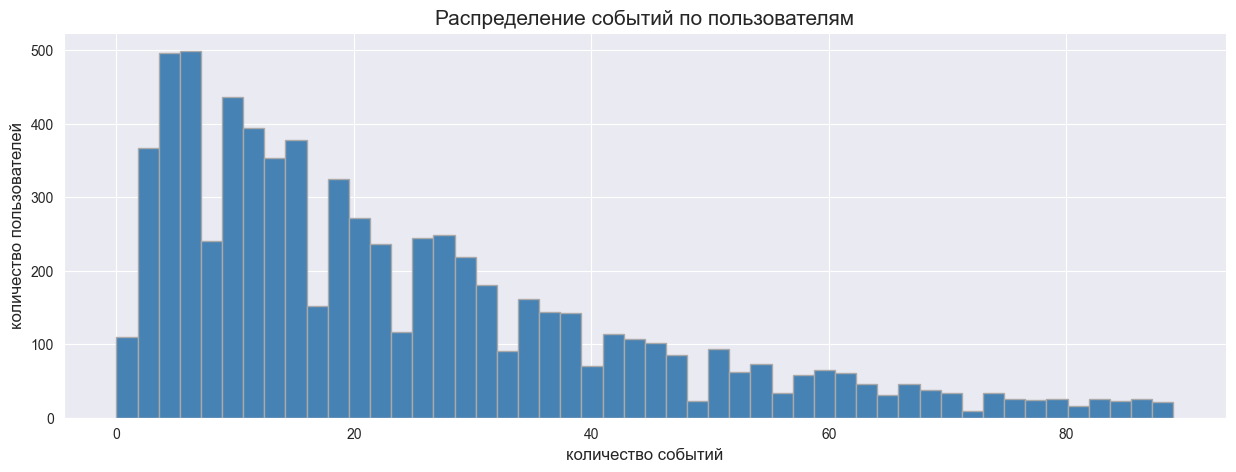

In [28]:
t.hist(bins=50, range=(0,t.quantile(0.95)), color='steelblue',figsize=(15, 5), ec="darkgrey")
plt.title('Распределение событий по пользователям', fontsize=15) 
plt.xlabel('количество событий', fontsize=12) 
plt.ylabel('количество пользователей', fontsize=12) 
plt.show()

В среднем на пользователя приходится 32 события, минимальное значение 1, максимальное 2307, медиана 20

Посмотрим данным за какой период мы располагаем 

In [29]:
print( f'Минимальная дата {df["date"].min()}, максимльаня дата {df["date"].max()}')

Минимальная дата 2019-07-25, максимльаня дата 2019-08-07


In [30]:
(df["date_time"].max() - df["date_time"].min()) / np.timedelta64 ( 1 , 'D')

13.68866898148148

У нас есть данные с 25-07-2019 по 07-08-2019, что составляет две недели

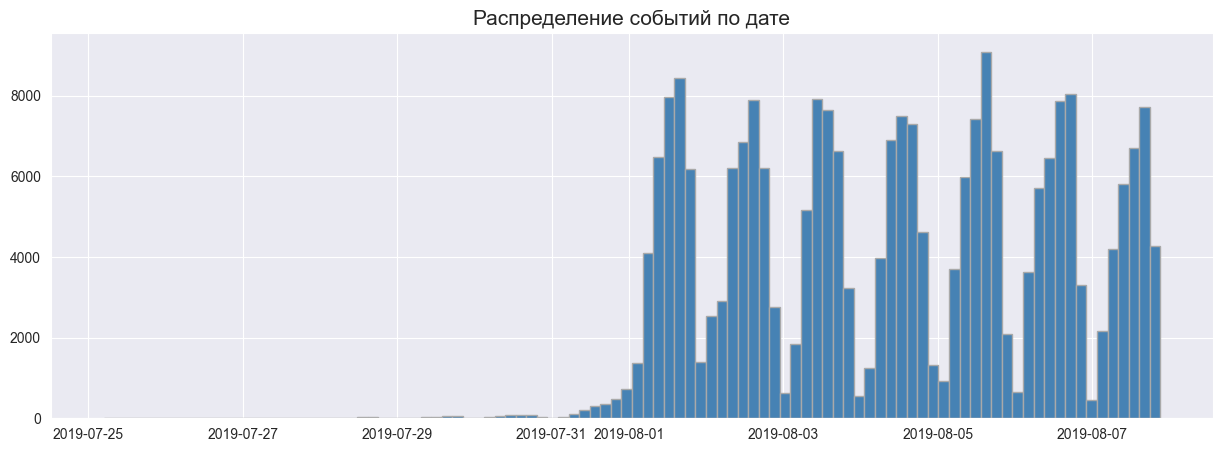

In [31]:
df['date_time'].hist(bins=100, color='steelblue',figsize=(15, 5), ec="darkgrey")
plt.title('Распределение событий по дате', fontsize=15)
plt.show()

По графику видно, что одинаково полные данные у нас есть за период с 01-08-2019 по 07-08-2019, что составляет неделю 

In [32]:
not_relevant = df[df['date_time'] < '2019-08-01 00:00:00']
not_relevant.head()

,eventname,user_id,eventtimestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [33]:
print( f'Процент записей, которые мы исключаем от общего числа записей {np.round(len(not_relevant) / len(df) * 100, decimals = 2)} %')

Процент записей, которые мы исключаем от общего числа записей 1.16 %


Посмотрим, какие данные мы хотим удалить.

In [34]:
print('Количество уникальных значений в каждой колонке:')
for index in not_relevant.columns:
    row = not_relevant[index].nunique()
    print(f'Уникальный значений {index}: {row}')

Количество уникальных значений в каждой колонке:
Уникальный значений eventname: 5
Уникальный значений user_id: 1451
Уникальный значений eventtimestamp: 2610
Уникальный значений group: 3
Уникальный значений date_time: 2610
Уникальный значений date: 7


In [35]:
np.round(not_relevant['user_id'].nunique() / df['user_id'].nunique() * 100, decimals = 2)

19.22

In [36]:
df = df[df['date_time'] >= '2019-08-01 00:00:00'].copy()

In [37]:
total_unique_users - df['user_id'].nunique()

17

In [38]:
(total_unique_users - df['user_id'].nunique()) / total_unique_users  * 100

0.22513574361011784

Отбросили чуть более 1% данных от общего числа записей. Почти 20% процентов уникальных пользователей попали в этом временной отрезок. 17 пользователей в будущем не пользовались приложением в нашем исследовании, что составляет менее 0,3% уникальных пользователей.  
Построим новый график распределения событий 

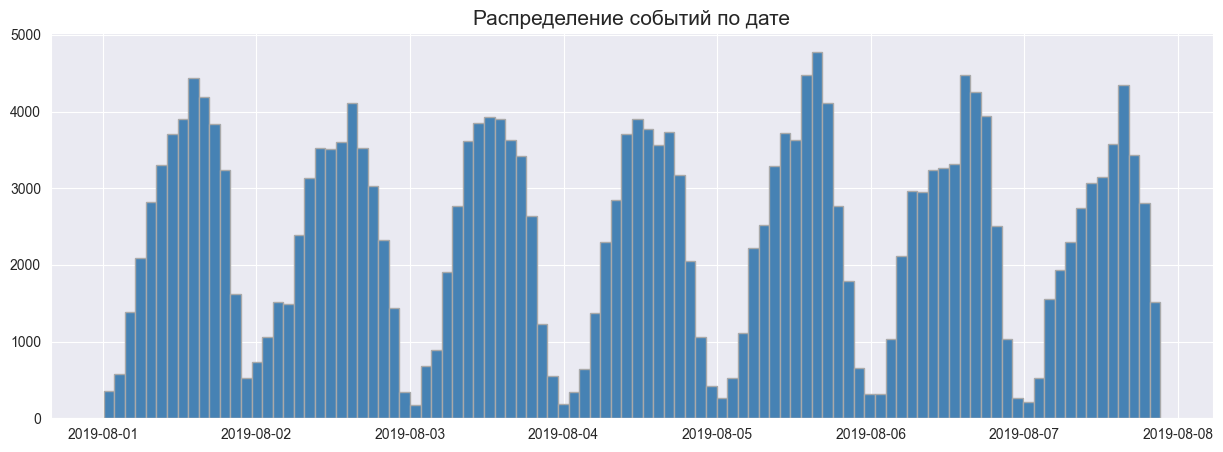

In [39]:
df['date_time'].hist(bins=100, color='steelblue',figsize=(15, 5), ec="darkgrey")
plt.title('Распределение событий по дате', fontsize=15)
plt.show()

На вид гарфик получился "полный", активность приходится на дневное время.  
Посмотрим, что осталось

In [40]:
print('Количество уникальных значений в каждой колонке:')
for index in df.columns:
    row = df[index].nunique()
    print(f'Уникальный значений {index}: {row}')

Количество уникальных значений в каждой колонке:
Уникальный значений eventname: 5
Уникальный значений user_id: 7534
Уникальный значений eventtimestamp: 174044
Уникальный значений group: 3
Уникальный значений date_time: 174044
Уникальный значений date: 7


Мы удалили всего 17 пользователей, но при это более 1% данных.   
Давайте еще раз посомтрим на распределение действий пользователей по группам, после предобработки

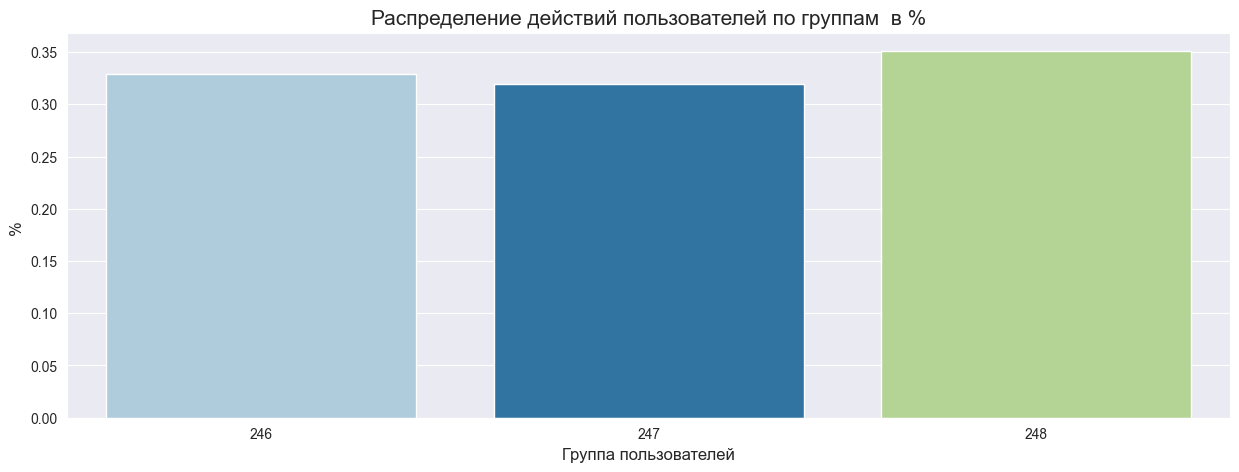

In [41]:
t = df["group"].value_counts(normalize=True)

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Группа пользователей',fontsize=12)
g.set_ylabel('% ', fontsize=12)
g.set_title('Распределение действий пользователей по группам  в %', fontsize=15)
plt.show()

Существенных изменений нет

**Вывод:**  
Привели столбцы к нижнему регистру, добавили два новых столбца `date_time` и `date`, удалили 413 дубликатов, 17 пользователей и чуть более 1% данных. Посмотрели на распределение событий по пользователям.  
Установили период анализа с `01-08-2019` по `07-08-2019`. 

### Воронка событий

Посмотрим, какие события есть в логах, как часто они встречаются.

In [42]:
df['eventname'].value_counts(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

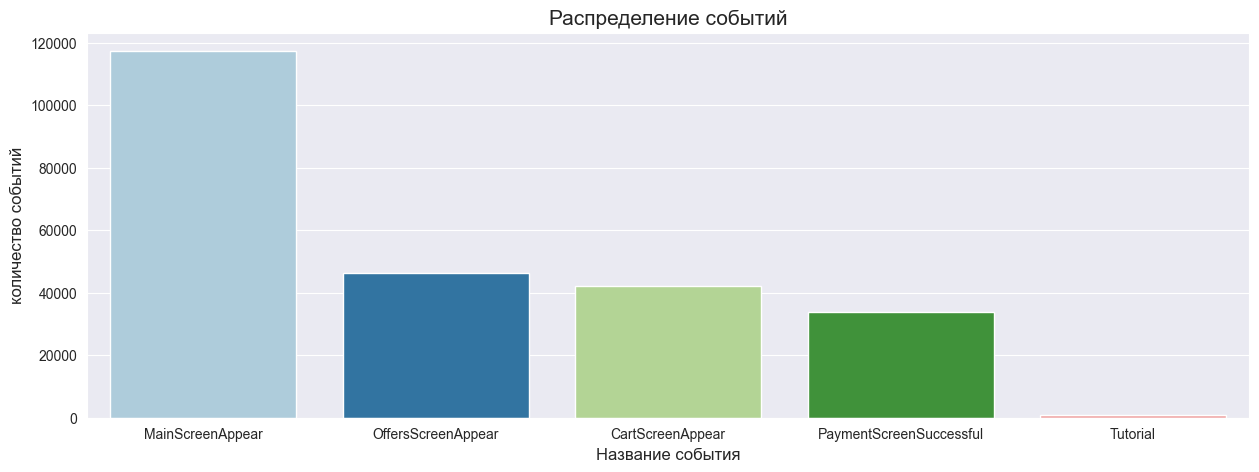

In [43]:
plt.figure(figsize=(15,5))
g = sns.barplot(x=df["eventname"].value_counts().index, y=df["eventname"].value_counts().values,  palette='Paired')
g.set_xlabel('Название события',fontsize=12)
g.set_ylabel('количество событий', fontsize=12)
g.set_title('Распределение событий', fontsize=15)
plt.show()

Посчитаем, сколько пользователей совершали каждое из этих событий, нейдем долю пользователей, которые хоть раз совершали событие.

In [44]:
events_by_users = (df.groupby('eventname', as_index=False)
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))
events_by_users['percent_all_user'] = (events_by_users['user_id'] / df['user_id'].nunique() * 100).round(2)
events_by_users

,eventname,user_id,percent_all_user
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


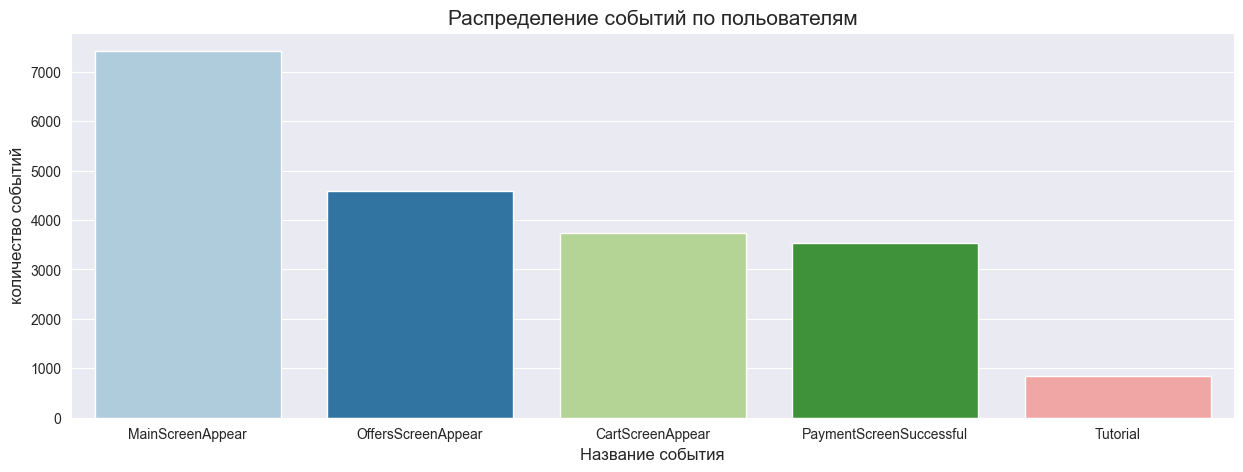

In [45]:
plt.figure(figsize=(15,5))
g = sns.barplot(x=events_by_users['eventname'], y=events_by_users['user_id'],  palette='Paired')
g.set_xlabel('Название события',fontsize=12)
g.set_ylabel('количество событий', fontsize=12)
g.set_title('Распределение событий по польователям', fontsize=15)
plt.show()

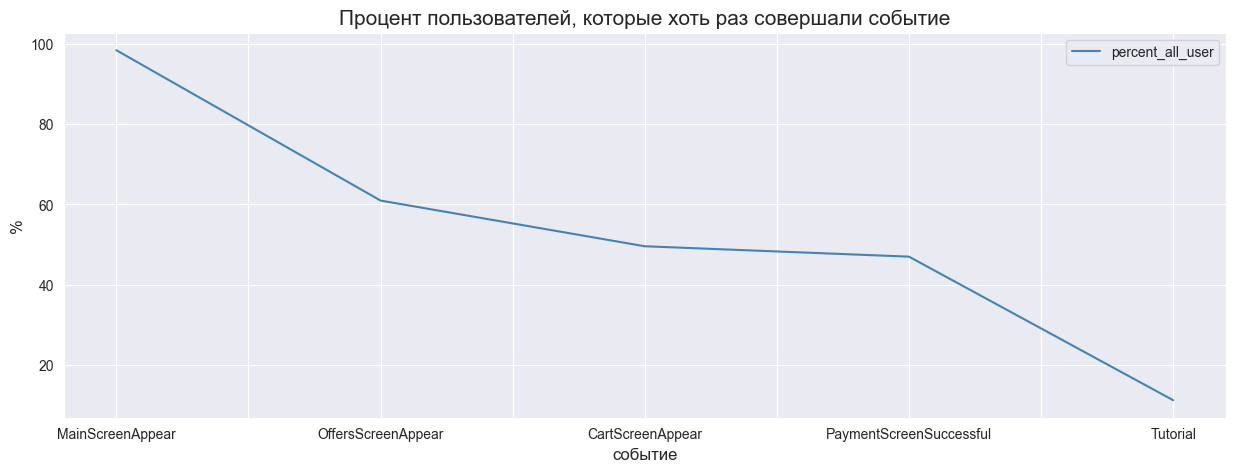

In [46]:
events_by_users.plot(x= 'eventname', y='percent_all_user', figsize=(15,5), color='steelblue')
plt.title('Процент пользователей, которые хоть раз совершали событие', fontsize=15)
plt.xlabel('событие', fontsize=12)
plt.ylabel('%', fontsize=12) 
plt.show() 

Почти все пользователи бывают на главной странице и порядка половины производят оплату.  
Посмотрим на 1,5 % пользователей, котрые ни разу не был на основной странице.

In [47]:
difference_1 = np.setdiff1d(df['user_id'].unique(), df[df['eventname'] == 'MainScreenAppear']['user_id'].unique())
len(difference_1)

115

In [48]:
wrong_user = df.query('user_id in @ difference_1')[['eventname', 'user_id']]
wrong_user_pivot = (wrong_user.groupby('eventname', as_index=False)
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))
wrong_user_pivot['percent_all_user'] = (wrong_user_pivot['user_id'] / wrong_user['user_id'].nunique() * 100).round(2)
wrong_user_pivot

,eventname,user_id,percent_all_user
1,OffersScreenAppear,111,96.52
0,CartScreenAppear,99,86.09
2,PaymentScreenSuccessful,98,85.22
3,Tutorial,4,3.48


Из этих 115 пользователей 4 не было и на `OffersScreenAppear`, посмотрим кто это и какие действия они совершали в приложении.

In [49]:
difference_2 = np.setdiff1d(wrong_user['user_id'].unique(), 
                            wrong_user[wrong_user['eventname'] == 'OffersScreenAppear']['user_id'].unique())
len(difference_2)

4

In [50]:
df.query('user_id in @ difference_2')[['eventname', 'user_id']]

,eventname,user_id
103577,Tutorial,2525867977967066505
103658,Tutorial,2525867977967066505
103994,Tutorial,2525867977967066505
169985,Tutorial,3800345857856674685
169993,Tutorial,3800345857856674685
187384,Tutorial,4530866328707864508
189200,Tutorial,7914773194539807942


4 пользователя заходили, читали инструкцию  и далее не продвигались  

Посмотрим, на какую страницу приложения попадают наши пользователи при первом посещении

In [51]:
profiles = (df.sort_values(by=['user_id', 'date_time']).groupby('user_id')
            .agg({'eventname': 'first', 'date_time': 'first'})
            .rename(columns={'eventname': 'first_step'}).reset_index())

In [52]:
profiles['first_step'].value_counts()

MainScreenAppear           6305
Tutorial                    783
OffersScreenAppear          288
PaymentScreenSuccessful      96
CartScreenAppear             62
Name: first_step, dtype: int64

Посмотрим распределение на графике

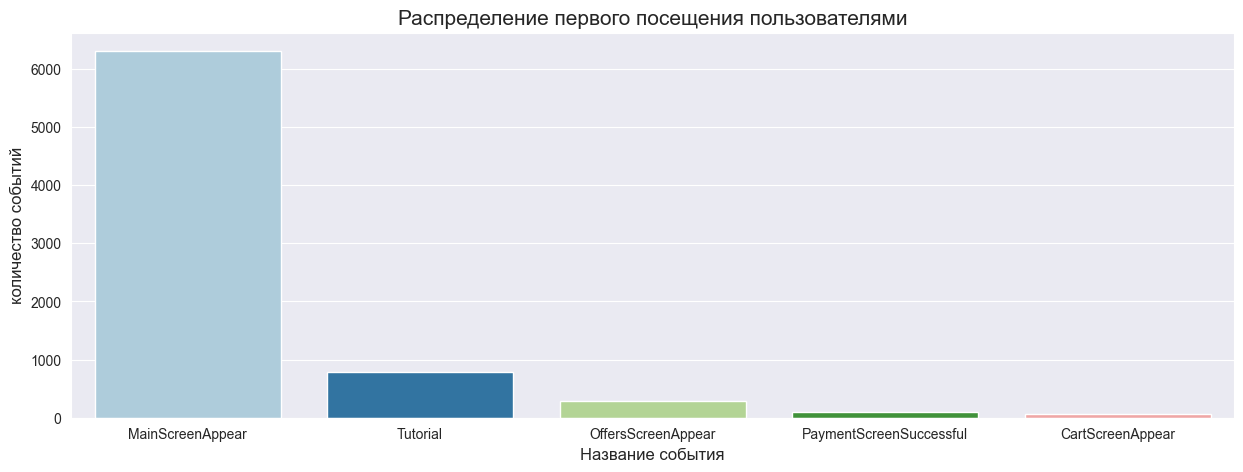

In [53]:
plt.figure(figsize=(15,5))
g = sns.barplot(x=profiles['first_step'].value_counts().index, y=profiles['first_step'].value_counts().values,  palette='Paired')
g.set_xlabel('Название события',fontsize=12)
g.set_ylabel('количество событий', fontsize=12)
g.set_title('Распределение первого посещения пользователями', fontsize=15)
plt.show()

Для наглядности посмотрим процентное соотношение 

In [54]:
profiles['first_step'].value_counts(ascending=False, normalize=True)

MainScreenAppear           0.836873
Tutorial                   0.103929
OffersScreenAppear         0.038227
PaymentScreenSuccessful    0.012742
CartScreenAppear           0.008229
Name: first_step, dtype: float64

Чаше всего пользователи при первом посещении оказываются на главной странице, порядка 10% в `Tutorial`, остальные группы не значительные.    
Изначально я думал удалить `115` пользователей, которые ни разу не были на главном экране, но тк пользователи могут зайти в приложение сразу на любую страницу, оставим их пока в нашем исследовании.  
Посмотрим через сколько уникальных событий проходят пользователи

In [55]:
number_actions = (df.groupby('user_id')['eventname'].nunique()
                  .reset_index().rename(columns={'eventname': 'actions'})
                  .sort_values(by='actions', ascending=False))
number_actions.head()

,user_id,actions
3717,4632680059380639630,5
2745,3461821332318259564,5
6315,7766250438405005043,5
4922,6098605206430780449,5
1918,2438520924615884865,5


In [56]:
number_actions[number_actions['actions'] == 5]['user_id'].count()

466

466 пользователей производили все 5 действий, исключим `Tutorial` и посмотрим сколько пользователей совершали 4 действия

In [57]:
number_actions_not_tutorial = (df[df['eventname'] != 'Tutorial'].groupby('user_id')['eventname'].nunique()
                  .reset_index().rename(columns={'eventname': 'actions'})
                  .sort_values(by='actions', ascending=False))
number_actions_not_tutorial.head()

,user_id,actions
5455,6781698214241776515,4
2332,2956577131512679581,4
4154,5153489763805063987,4
6615,8140776447850438862,4
6614,8139584978936500733,4


In [58]:
buy_users_all = events_by_users[events_by_users['eventname'] == 'PaymentScreenSuccessful']['user_id'].sum()

In [59]:
buy_users_4 = number_actions_not_tutorial[number_actions_not_tutorial['actions'] == 4]['user_id'].count()

In [60]:
buy_users_all - buy_users_4

110

Из `3539` покупок `3429` пользователей совершали все 4 действия.  
Посмотрим кто совершил покупку без захождения в `Tutorial` и `MainScreenAppear`

In [61]:
number_actions_not_tutorial_and_MainScreen = (df.query('eventname != ["Tutorial", "MainScreenAppear"]').groupby('user_id')['eventname'].nunique()
                  .reset_index().rename(columns={'eventname': 'actions'})
                  .sort_values(by='actions', ascending=False))
number_actions_not_tutorial_and_MainScreen.head()

,user_id,actions
0,6909561520679493,3
2381,4787845142725261278,3
2370,4758223822167675176,3
2371,4759088403179470508,3
2372,4764332977806468729,3


In [62]:
buy_users_3 = number_actions_not_tutorial_and_MainScreen[number_actions_not_tutorial_and_MainScreen['actions'] == 3]['user_id'].count()

In [63]:
print(buy_users_3 - buy_users_4)
print(buy_users_all - buy_users_3)

98
12


Добавилось 98 пользователей, осталось 12 пользователей, давайте посмотрим кто это и что они делали в приложении

In [64]:
t = number_actions_not_tutorial_and_MainScreen[number_actions_not_tutorial_and_MainScreen['actions'] == 3]['user_id']
t_2 = df[df['eventname'] == 'PaymentScreenSuccessful']['user_id']
t_2 = pd.DataFrame(data=t_2)
t_3 = t_2.query('user_id not in @ t')['user_id']

In [65]:
(df.query('user_id in @t_3').groupby('user_id')['eventname'].nunique()
                  .reset_index().rename(columns={'eventname': 'actions'})
                  .sort_values(by='actions', ascending=False)).iloc[:3]

,user_id,actions
3,1872850747466641334,4
0,217208764195819861,3
1,1568403033187645799,3


In [66]:
df.query('user_id in @t_3')['user_id'].nunique()

12

In [67]:
df[df['user_id'] == 1872850747466641334].sort_values(by='date_time').loc[143896:143978]

,eventname,user_id,eventtimestamp,group,date_time,date
143896,MainScreenAppear,1872850747466641334,1564984155,248,2019-08-05 05:49:15,2019-08-05
143897,CartScreenAppear,1872850747466641334,1564984159,248,2019-08-05 05:49:19,2019-08-05
143978,PaymentScreenSuccessful,1872850747466641334,1564984364,248,2019-08-05 05:52:44,2019-08-05


Из проведенного выше исследования, можно сделать вывод, что почти 97% пользователей, которые произвели оплату были на всех 4 страницах в приложении. При этом пользователь не обязательно следует по порядку и может переходить с одной страницы на другую и обратно.  

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [68]:
events_by_users = (df.groupby('eventname', as_index=False)
                   .agg({'user_id': 'nunique'})
                   .sort_values(by='user_id', ascending=False))
events_by_users['percent_all_user'] = (events_by_users['user_id'] / df['user_id'].nunique() * 100).round(2)
events_by_users = events_by_users.reset_index(drop=True)
events_by_users

,eventname,user_id,percent_all_user
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


In [69]:
events_by_users_shift = events_by_users
events_by_users_shift['percent_funnel'] = (events_by_users_shift['user_id'] / 
                                                events_by_users_shift['user_id'].shift() * 100)
events_by_users_shift = events_by_users_shift.fillna(100)
events_by_users_shift.style.format({'percent_funnel':'{:.2f}%', 'percent_all_user':'{:.2f}%'})

,eventname,user_id,percent_all_user,percent_funnel
0,MainScreenAppear,7419,98.47%,100.00%
1,OffersScreenAppear,4593,60.96%,61.91%
2,CartScreenAppear,3734,49.56%,81.30%
3,PaymentScreenSuccessful,3539,46.97%,94.78%
4,Tutorial,840,11.15%,23.74%


In [70]:
for i in events_by_users.index:
    if i == 0:
        events_by_users.loc[i, 'percent_funnel'] = 100
    else:
        events_by_users.loc[i, 'percent_funnel'] = np.round(events_by_users.loc[i, 'user_id'] 
                                                            / events_by_users.loc[i - 1, 'user_id'] * 100, decimals = 2)
events_by_users = events_by_users[['eventname', 'user_id', 'percent_funnel', 'percent_all_user']]
events_by_users.iloc[0:4]

,eventname,user_id,percent_funnel,percent_all_user
0,MainScreenAppear,7419,100.00,98.47
1,OffersScreenAppear,4593,61.91,60.96
2,CartScreenAppear,3734,81.30,49.56
3,PaymentScreenSuccessful,3539,94.78,46.97


In [71]:
funnel = events_by_users[0:4].copy()
percent = funnel['percent_funnel'].round().astype(int).astype(str)
percent = percent.apply(lambda x: x + '%')

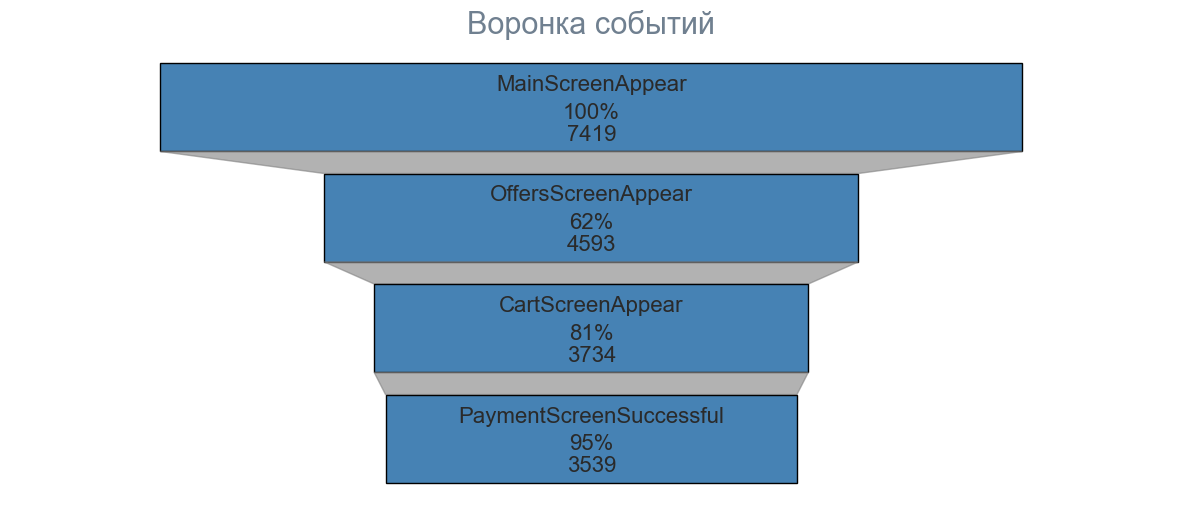

In [72]:
y = [4,3,2, 1]
x = funnel['user_id']
labels = funnel['eventname']
percent = percent 
x_max = 10000
x_min = 0
x_range = x_max - x_min

fig, ax = plt.subplots(1, figsize=(15,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, color='steelblue',
             height=.8, edgecolor='black')
    # label
    plt.text(5000, y[idx]+0.15, labels[idx], ha='center', 
              fontsize=16, color='#2A2A2A')
    # value
    plt.text(5000, y[idx]-0.3, x[idx], ha='center',
              fontsize=16, color='#2A2A2A')
    # percent
    plt.text(5000, y[idx]-0.1, percent[idx], ha='center',
              fontsize=16, color='#2A2A2A')
    
    #plt.plot([left, 10000-left], [y[idx], y[idx]])

    if idx != len(x)-1:
        next_left = (x_range - x[idx+1])/2
        shadow_x = [left, next_left, 
                    10000-next_left, 10000-left, left]
        
        shadow_y = [y[idx]-0.4, y[idx+1]+0.4, 
                    y[idx+1]+0.4, y[idx]-0.4, y[idx]-0.4]
        plt.fill(shadow_x, shadow_y, color='grey', alpha=0.6)   

plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка событий',  loc='center', fontsize=22, color='slategray')
plt.show()

Большая часть пользователей теряется после первого шага, далее конверсия выглядит высокой.  
Посмотрим какая доля пользователей доходит от первого события до оплаты

In [73]:
np.round(events_by_users.loc[3, 'user_id'] / events_by_users.loc[0, 'user_id'] * 100, decimals = 2)

47.7

Порядка 48% пользователей, которые были на главном экране доходят до оплаты.

**Вывод:**  
Почти 97% пользователей, которые произвели оплату были на всех 4 страницах в приложении. При этом пользователь не обязательно следует по порядку и может переходить с одной страницы на другую и обратно. Из 7419 уникальных пользователей на главной странице, в раздел `OffersScreenAppear` заглядывало только 62%. С вероятностью в 95% если товар добавили в корзину, будет произведена оплата.

###  Результаты эксперимента

Посмотрим еше раз на наших пользователей в каждой группе

In [74]:
df["group"].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [75]:
unique_user = df.groupby('group')['user_id'].nunique()
unique_user

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

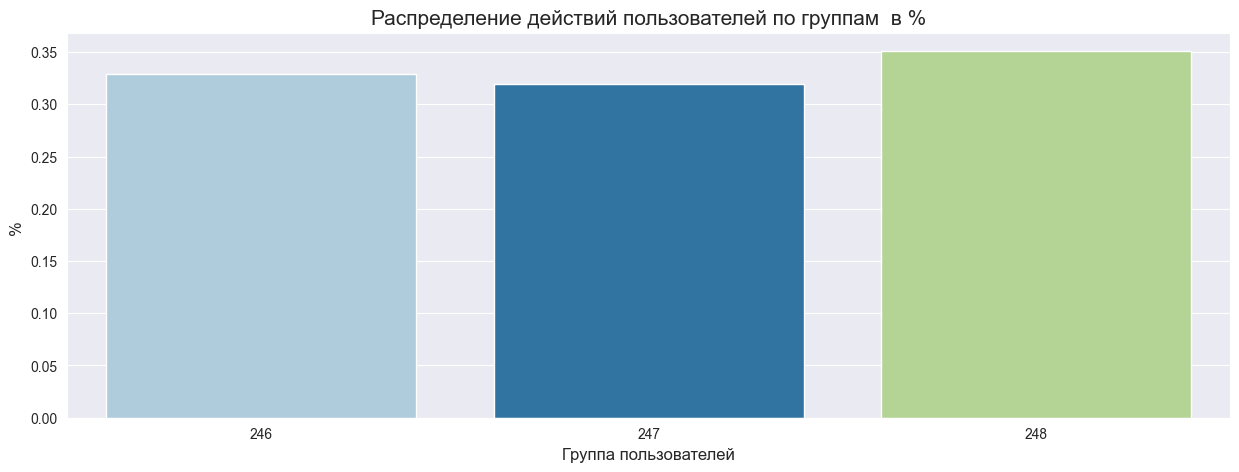

In [76]:
t = df["group"].value_counts(normalize=True)

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Группа пользователей',fontsize=12)
g.set_ylabel('% ', fontsize=12)
g.set_title('Распределение действий пользователей по группам  в %', fontsize=15)
plt.show()

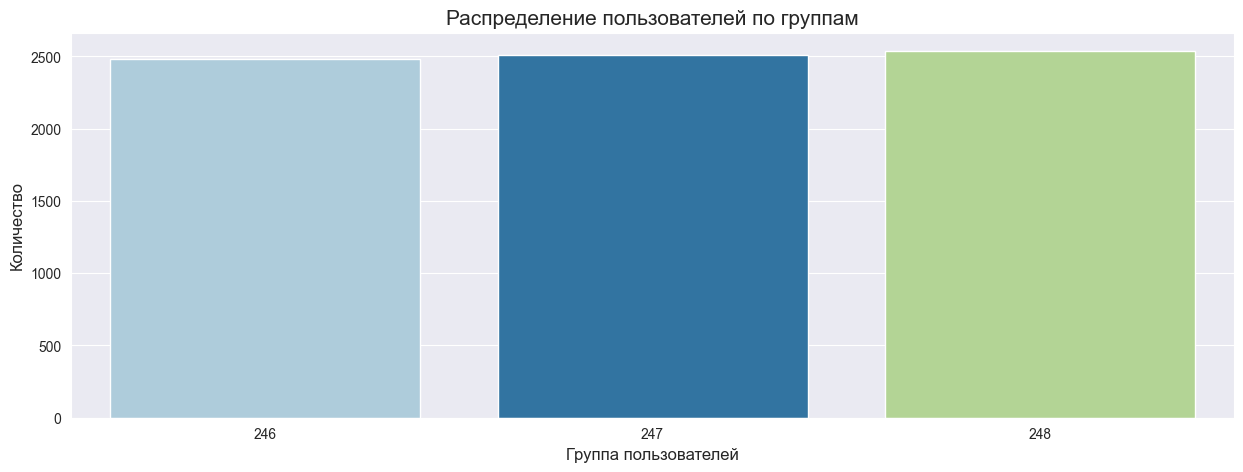

In [77]:
t = df.groupby('group')['user_id'].nunique()

plt.figure(figsize=(15,5))
g = sns.barplot(x=t.index, y=t.values,  palette='Paired')
g.set_xlabel('Группа пользователей',fontsize=12)
g.set_ylabel('Количество', fontsize=12)
g.set_title('Распределение пользователей по группам', fontsize=15)
plt.show()

Визуально пользователи распределены нормально.  
Проверим, что пользователи в группах не пересекаются

In [78]:
intersect_1 = np.intersect1d(df.query('group == "246"')['user_id'], df.query('group == "247"')['user_id'])
intersect_2 = np.intersect1d(df.query('group == "246"')['user_id'], df.query('group == "248"')['user_id'])
intersect_3 = np.intersect1d(df.query('group == "247"')['user_id'], df.query('group == "248"')['user_id'])
print(len(intersect_1), len(intersect_2), len(intersect_3))

0 0 0


Сплитование трафика произведено корректно, пользователи не пересекаются.  
Посмотрим на распределение событий по группам

In [79]:
group_events_by_users = df.pivot_table(index='eventname', columns='group', values='user_id', aggfunc='nunique').reset_index()
group_events_by_users.columns= ['eventname', '246', '247', '248']
group_events_by_users.rename(index={0:2, 1:0, 2:1, 3:3, 4:4}, inplace= True )
group_events_by_users = group_events_by_users.sort_index()
group_events_by_users

,eventname,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


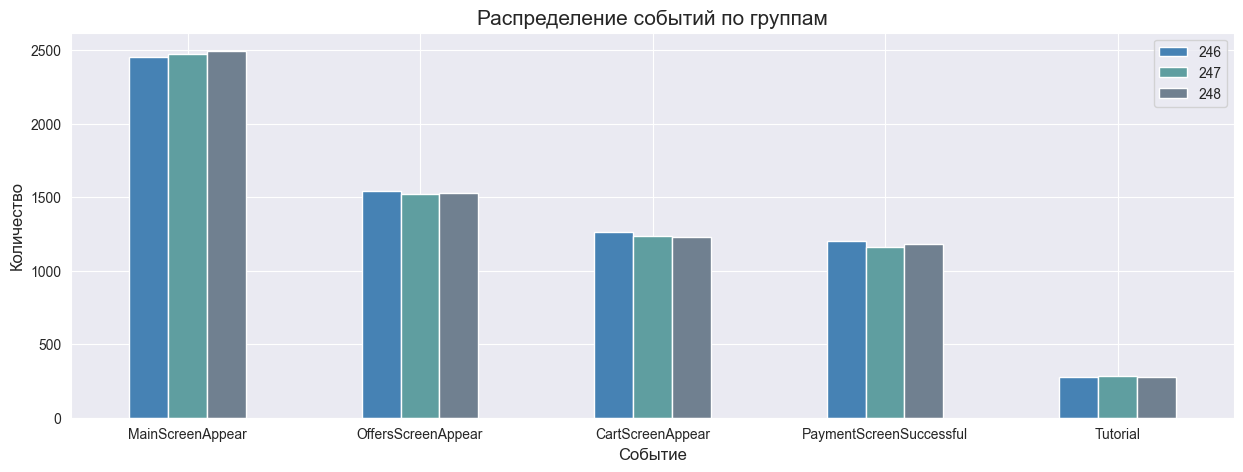

In [80]:
group_events_by_users.plot(x='eventname', kind='bar', figsize=(15,5), color =['steelblue', 'cadetblue', 'slategray'])
plt.title( 'Распределение событий по группам', fontsize=15)
plt.xlabel('Cобытие', fontsize=12), 
plt.ylabel('Количество', fontsize=12) 
plt.xticks(rotation=0)
plt.show()

Визуально события в разрезе по группам распределены нормально, воронка событий внешне похожа на общую воронку. 
Удалим из `group_events_by_users` событие `Tutorial` .  

In [81]:
group_events_by_users = group_events_by_users.loc[0:3]

Проверим равенство средних значений наших выборок с помощью `z-критерия`.    
Сформулируем гипотезы.  
`Нулевая`: Нет статистически значимого различия, нет оснований считать доли разными.  
`Альтернативная`: Между долями есть значимая разница, отвергаем нулевую гипотезу.  
Критический уровень статистической значимости укажем `0,05`  
Передадим в функцию `all_group_z_test` номер первой группы и функция выведет результаты для трех групп попарно  

In [82]:
all_group_z_test(246)

Статистически значимые различая между группами 246 и 247 для события MainScreenAppear
p-значение:  [0.75705972]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события OffersScreenAppear
p-значение:  [0.24809546]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события CartScreenAppear
p-значение:  [0.22883372]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события PaymentScreenSuccessful
p-значение:  [0.11456679]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---




Статистически значимые различая между группами 247 и 248 для события MainScreenAppear
p-значение:  [0.45870536]
значение

Мы сравнили все три группы попарно, для 4 категорий действий, получили 12 результатов, вывод одинаковый:  
`Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными`  
Но нам надо применить поправку Бонферрони для минимизации рисков

In [83]:
all_group_z_test(246, bonferroni_alpha = 12)

Статистически значимые различая между группами 246 и 247 для события MainScreenAppear
p-значение:  [0.75705972]
значение alpha: 0.004166666666666667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события OffersScreenAppear
p-значение:  [0.24809546]
значение alpha: 0.004166666666666667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события CartScreenAppear
p-значение:  [0.22883372]
значение alpha: 0.004166666666666667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами 246 и 247 для события PaymentScreenSuccessful
p-значение:  [0.11456679]
значение alpha: 0.004166666666666667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---




Статистически значимые различая между группами 247 и 248

Объединим группы 246 и 247 и сравним полученную группу с 248

In [84]:
df['a_b'] = 'A'
df['a_b'] = np.where(df['group'] == 248, 'B', 'A')

In [85]:
a_b_group = df.groupby('a_b')['user_id'].nunique()
a_b_group

a_b
A    4997
B    2537
Name: user_id, dtype: int64

In [86]:
a_b_events_by_users = df.pivot_table(index='eventname', columns='a_b', values='user_id', aggfunc='nunique').reset_index()[:4]
a_b_events_by_users

a_b,eventname,A,B
0,CartScreenAppear,2504,1230
1,MainScreenAppear,4926,2493
2,OffersScreenAppear,3062,1531
3,PaymentScreenSuccessful,2358,1181


Проверим равенство средних значений групп А и В с помощью `z-критерия`.    
Сформулируем гипотезы.  
`Нулевая`: Нет статистически значимого различия, нет оснований считать доли разными.  
`Альтернативная`: Между долями есть значимая разница, отвергаем нулевую гипотезу.  
Критический уровень статистической значимости укажем `0,05`

In [87]:
for i in a_b_events_by_users['eventname'].unique():
    print(f'Статистически значимые различая между группами A и B для события {i}')
    z_test(a_b_events_by_users.loc[a_b_events_by_users['eventname'] == i, 'A'], 
           a_b_events_by_users.loc[a_b_events_by_users['eventname'] == i, 'B'], 
           trials_1 = a_b_group.loc['A'], 
           trials_2 = a_b_group.loc['B'])
    print()
    print('---')
    print()

Статистически значимые различая между группами A и B для события CartScreenAppear
p-значение:  [0.18175875]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события MainScreenAppear
p-значение:  [0.29424527]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события OffersScreenAppear
p-значение:  [0.4342555]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события PaymentScreenSuccessful
p-значение:  [0.60042943]
значение alpha: 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---



Применим поправку Бонферрони для минимизации рисков

In [88]:
for i in a_b_events_by_users['eventname'].unique():
    print(f'Статистически значимые различая между группами A и B для события {i}')
    z_test(a_b_events_by_users.loc[a_b_events_by_users['eventname'] == i, 'A'], 
           a_b_events_by_users.loc[a_b_events_by_users['eventname'] == i, 'B'], 
           trials_1 = a_b_group.loc['A'], 
           trials_2 = a_b_group.loc['B'],
           bonferroni_alpha = 4)
    print()
    print('---')
    print()

Статистически значимые различая между группами A и B для события CartScreenAppear
p-значение:  [0.18175875]
значение alpha: 0.0125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события MainScreenAppear
p-значение:  [0.29424527]
значение alpha: 0.0125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события OffersScreenAppear
p-значение:  [0.4342555]
значение alpha: 0.0125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---

Статистически значимые различая между группами A и B для события PaymentScreenSuccessful
p-значение:  [0.60042943]
значение alpha: 0.0125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---



При обьединение групп резульат теста не изменился, что было ожидаемым.

**Вывод:**  
Мы провели 16 проверок статистических гипотез, результат:  
`Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными`

### Общий вывод

Дизайнеры захотели поменять шрифты во всём приложении, было принято решение провести А/А/Б тестирование.  
Нам для исследования предоставили датафйрем в котором каждая запись в логе — это действие пользователя, или событие.
В таблице пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.
Всего 244126 записей. Во время предобработки мы удалили 413 дубликатов и выбрали период анализа с 01-08-2019 по 07-08-2019.  
Мы изучили поведение пользователей в приложении, чуть более 80% попадаю сразу на главный экран, около 10% сначала заходят в инструкцию и далее уже начинают пользоваться приложением. Только 4 человека после изучения Tutorial покинули приложение.  
Почти 97% пользователей, которые произвели оплату были на всех 4 страницах в приложении. При этом пользователь не обязательно следует по порядку и может переходить с одной страницы на другую и обратно, 48% пользователей, которые были на главном экране доходят до оплаты. Из 7419 уникальных пользователей на главной странице, в раздел OffersScreenAppear заглядывало только 62%. С вероятностью в 95% если товар добавили в корзину, будет произведена оплата.  
Мы убедились что нет статистически значимых различай между группами А/А, и сравнили контрольные группы с экспериментальной, как по отдельности, так и вместе.  
По результатам тестов нам не удалось обнаружить статистически значимой разницы между группами.  
Изменение шрифтов не сказались на поведении пользователей.  
Нет смысла применять настройки группы В для всех пользователей.  

**Чек-лист готовности проекта**

- [x] Замените названия столбцов на удобные для вас
- [x] Проверьте пропуски и типы данных. Откорректируйте, если нужно
- [x] Добавьте столбец даты и времени, а также отдельный столбец дат; 
---------------------
- [x] Сколько всего событий в логе?
- [x] Сколько всего пользователей в логе?
- [x] Сколько в среднем событий приходится на пользователя?
- [x] Данными за какой период вы располагаете? ? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени
- [x] Много ли событий и пользователей вы потеряли, отбросив старые данные?
- [x] Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.
---------------------
- [x] Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте. 
- [x] Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие
- [x] Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки
- [x] По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B
- [x] На каком шаге теряете больше всего пользователей?
- [x] Какая доля пользователей доходит от первого события до оплаты?
---------------------
- [x] Сколько пользователей в каждой экспериментальной группе?
- [x] Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- [x] Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- [x] Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- [x] Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.